# Webinar 2: EOPF Sample Service - Hands-on with multiple Zarr files with Xarray 

```{image} https://raw.githubusercontent.com/annefou/eopf-sample-notebooks/refs/heads/pangeo/deforestation/notebooks/static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Set up a local cluster for distributed computing](#Set-up-a-local-cluster-for-distributed-computing)
- [Accessing multiple Zarr files](#Accessing-multiple-Zarr-files)
- [Compute cloudless NDVI](#Compute-cloudless-NDVI)
- [Indexing and selecting data](#Indexing-and-selecting-data)
- [Analysis](#Analysis)
- [Summary](#Summary)

(Introduction)=
## Introduction

Sentinel 2 data is one of the most popular satellite datasets, but it does come with challenges. Cloud-free mosaics have to be constructed often in order to get analysis-ready data. Accessing a lot of data through tiles takes a long time, and getting the data into a format it can be easily analysed in with common Python tools can be a challenge.

In this notebook, we will show how this whole process of getting analysis-ready data into Python can be sped up by using Zarr data from the EOPF Sample Service. This is being presented by running through a basic deforestation monitoring use-case. The notebook uses the popular xarray Python library to handle the multidimensional data.

The complete notebook showcasing how to leverage EOPF Sample Service for [Deforestation Monitoring using Sentinel 2 and xarray](https://github.com/annefou/eopf-sample-notebooks/blob/pangeo/deforestation/notebooks/Sentinel-2/deforestation_monitoring_zarr.ipynb) is still under construction but will be made available soon in the EOPF Sample Service Github Repository: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks

:::{hint} Overview
**Questions**
- How can we access Sentinel-2 data efficiently?
- How can we compute vegetation indices like NDVI in the cloud?
- How can we generate cloud-free mosaics for better analysis?
- How can we analyze changes in vegetation over time?
- How can we efficiently handle large EO datasets in Python?
  
**Objectives**
- Accessing Sentinel-2 data in the Copernicus Dataspace Ecosystem.
- Performing NDVI calculations using cloud-based processing.
- Creating monthly composites from Sentinel-2 data.
- Building a time series for deforestation monitoring.
- Loading and managing data using the Xarray library.
:::

(Setup)=
## Setup
Start installing and importing the necessary libraries

In [1]:
!pip install --upgrade "zarr>=3.0.6" "xarray>=2025.3.1" "dask[complete]"

In [2]:
import xarray as xr

xr.__version__

'2025.3.1'

In [3]:
import zarr

zarr.__version__

'3.0.7'

In [4]:
import os
import s3fs
from datetime import datetime

import numpy as np
import xarray as xr

import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import Map, Polygon
from shapely import geometry

from distributed import LocalCluster

(Set-up-a-local-cluster-for-distributed-computing)=
## Set up a local cluster for distributed computing

In [5]:
cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42741,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42825,Total threads: 2
Dashboard: http://127.0.0.1:45835/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:42205,


(Accessing-multiple-Zarr-files)=
## Accessing multiple Zarr files

We now want to access a time series in order to compute the yearly NDVI index, remove cloudy pixels, and perform other processing steps.

### List of available remote files 
Let's make a list of available files for this example. In the cell below, we list the available Zarr files in the bucket and print the first five filenames.

In [6]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefix = "tutorial_data/cpm_v253/"
# Create the S3FileSystem with a custom endpoint
fs = s3fs.S3FileSystem(
    anon=True, client_kwargs={"endpoint_url": "https://objectstore.eodc.eu:2222"}
)

# unregister handler to make boto3 work with CEPH
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
handler_to_unregister = handlers_to_unregister[0]
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handler_to_unregister
)

s3path = (
    "s3://" + f"{bucket}/{prefix}" + "S2A_MSIL2A_*_*_*_T32UPC_*.zarr"
)  # "S2A_MSIL2A_*_N0500_*_T32UPC_*.zarr"

remote_files = fs.glob(s3path)

prefix = "https://objectstore.eodc.eu:2222"
remote_product_path = prefix + remote_files[0]
paths = [f"{prefix}/{f}" for f in remote_files]
paths

['https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180601T102021_N0500_R065_T32UPC_20230902T045008.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180604T103021_N0500_R108_T32UPC_20230819T205634.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180611T102021_N0500_R065_T32UPC_20230714T225353.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180614T103021_N0500_R108_T32UPC_20230813T122609.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180621T102021_N0500_R065_T32UPC_20230827T073006.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180624T103021_N0500_R108_T32U

(Compute-cloudless-NDVI)=
## Compute cloudless NDVI
- Select the classification map variable (scl) to mask invalid pixels (e.g., no data, saturated, cloudy).
- Since the scl variable is available at a different spatial resolution (20m), it is interpolated to 10m resolution.
- Then, compute a cloud-free NDVI using the B04, B03, and B02 bands.

## Lets create full timeseries dataset for list of datasets we will use.
To create full timeseries, we need to extract the time information.  For the moment i do not know how to get time information from metadata, but only from the file name we make a function to get that information from the file name


In [7]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)

In [8]:
%%time

resolution_reflectance = "r60m"
reflectance = xr.open_mfdataset(
    paths[:],
    engine="zarr",
    chunks={},  # Let Dask use on-disk chunking
    group="/measurements/reflectance/" + resolution_reflectance,
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
)
reflectance

CPU times: user 4.98 s, sys: 1.09 s, total: 6.07 s
Wall time: 16.7 s


<xarray.Dataset> Size: 8GB
Dimensions:  (time: 109, y: 1830, x: 1830)
Coordinates:
  * x        (x) int64 15kB 600030 600090 600150 600210 ... 709650 709710 709770
  * y        (y) int64 15kB 5799990 5799930 5799870 ... 5690370 5690310 5690250
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b01      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b02      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b03      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b04      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b05      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b06      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b07      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b09      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b11      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b12      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>
    b8a      (time, y, x) uint16 730MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>

In [9]:
reflectance.b02

<xarray.DataArray 'b02' (time: 109, y: 1830, x: 1830)> Size: 730MB
dask.array<concatenate, shape=(109, 1830, 1830), dtype=uint16, chunksize=(1, 305, 305), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 15kB 600030 600090 600150 600210 ... 709650 709710 709770
  * y        (y) int64 15kB 5799990 5799930 5799870 ... 5690370 5690310 5690250
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

In [10]:
%%time
mask_l2a_classification = xr.open_mfdataset(
    paths[:],
    engine="zarr",
    chunks={},
    group="conditions/mask/l2a_classification/r60m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
)
mask_l2a_classification

CPU times: user 2.26 s, sys: 537 ms, total: 2.8 s
Wall time: 10.6 s


<xarray.Dataset> Size: 365MB
Dimensions:  (time: 109, y: 1830, x: 1830)
Coordinates:
  * x        (x) int64 15kB 600030 600090 600150 600210 ... 709650 709710 709770
  * y        (y) int64 15kB 5799990 5799930 5799870 ... 5690370 5690310 5690250
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    scl      (time, y, x) uint8 365MB dask.array<chunksize=(1, 305, 305), meta=np.ndarray>

## Desired resolution of our data

To speed up processing, we change the data to a coarsen resolution

In [13]:
# Define the resampling factor (10m to 200m = 20x)
factor = 10
reflectance_lr = reflectance.coarsen(x=factor, y=factor, boundary="trim").mean()
reflectance_lr

<xarray.Dataset> Size: 321MB
Dimensions:  (time: 109, y: 183, x: 183)
Coordinates:
  * x        (x) float64 1kB 6.003e+05 6.009e+05 ... 7.089e+05 7.095e+05
  * y        (y) float64 1kB 5.8e+06 5.799e+06 5.799e+06 ... 5.691e+06 5.691e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b01      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b02      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b03      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b04      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b05      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b06      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b07      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b09      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b11      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b12      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b8a      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>

In [14]:
band2 = "b02"
band3 = "b03"
band4 = "b04"
band8 = "b8a"

## Lets start computing
### Apply mask
First compute the mask value in the same resolution as B02, B03, B04, B08 and apply the mask per pixel

In [15]:
%%time
scl_reflectance_lr = (
    mask_l2a_classification.scl.chunk(chunks={"x": -1, "y": -1}).interp(
        x=reflectance_lr["x"], y=reflectance_lr["y"], method="nearest"
    )
    # Copy chunking from r10m['b02'] to cls_r10m
    .chunk(reflectance_lr[band2].chunks)
)
scl_reflectance_lr

CPU times: user 147 ms, sys: 16.4 ms, total: 163 ms
Wall time: 155 ms


<timed exec>:6: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.


<xarray.DataArray 'scl' (time: 109, y: 183, x: 183)> Size: 29MB
dask.array<rechunk-merge, shape=(109, 183, 183), dtype=float64, chunksize=(1, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * x        (x) float64 1kB 6.003e+05 6.009e+05 ... 7.089e+05 7.095e+05
  * y        (y) float64 1kB 5.8e+06 5.799e+06 5.799e+06 ... 5.691e+06 5.691e+06
Attributes:
    _eopf_attrs:     {'coordinates': ['x', 'y'], 'dimensions': ['y', 'x']}
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    proj:epsg:       32632
    proj:shape:      [1830, 1830]
    proj:transform:  [60.0, 0.0, 600000.0, 0.0, -60.0, 5800020.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...

In [16]:
%%time


def validate_scl(scl):
    invalid = [0, 1, 3, 7, 8, 9, 10]  # NO_DATA, SATURATED, CLOUD, etc.
    return ~scl.isin(invalid)


valid_mask = validate_scl(scl_reflectance_lr)  # Boolean mask (10980x10980)
valid_mask

CPU times: user 33.9 ms, sys: 3.95 ms, total: 37.9 ms
Wall time: 36.5 ms


<xarray.DataArray 'scl' (time: 109, y: 183, x: 183)> Size: 4MB
dask.array<invert, shape=(109, 183, 183), dtype=bool, chunksize=(1, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * x        (x) float64 1kB 6.003e+05 6.009e+05 ... 7.089e+05 7.095e+05
  * y        (y) float64 1kB 5.8e+06 5.799e+06 5.799e+06 ... 5.691e+06 5.691e+06

In [17]:
%%time
# Apply mask per pixel, keep spatial dims
valid_lr = reflectance_lr.where(valid_mask)
valid_lr

CPU times: user 11.9 ms, sys: 10 µs, total: 11.9 ms
Wall time: 11.5 ms


<xarray.Dataset> Size: 321MB
Dimensions:  (time: 109, y: 183, x: 183)
Coordinates:
  * x        (x) float64 1kB 6.003e+05 6.009e+05 ... 7.089e+05 7.095e+05
  * y        (y) float64 1kB 5.8e+06 5.799e+06 5.799e+06 ... 5.691e+06 5.691e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b01      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b02      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b03      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b04      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b05      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b06      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b07      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b09      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b11      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b12      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>
    b8a      (time, y, x) float64 29MB dask.array<chunksize=(1, 30, 30), meta=np.ndarray>

### Apply scaling factor and add offset

In [18]:
%%time
red = (
    valid_lr[band4] * valid_lr[band4].attrs["_eopf_attrs"]["scale_factor"]
    + valid_lr[band4].attrs["_eopf_attrs"]["add_offset"]
)


nir = (
    valid_lr[band8] * valid_lr[band8].attrs["_eopf_attrs"]["scale_factor"]
    + valid_lr[band8].attrs["_eopf_attrs"]["add_offset"]
)

ndvi = (nir - red) / (nir + red)  # Per-pixel NDVI
ndvi

CPU times: user 14 ms, sys: 1.78 ms, total: 15.8 ms
Wall time: 15.1 ms


<xarray.DataArray (time: 109, y: 183, x: 183)> Size: 29MB
dask.array<truediv, shape=(109, 183, 183), dtype=float64, chunksize=(1, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1kB 6.003e+05 6.009e+05 ... 7.089e+05 7.095e+05
  * y        (y) float64 1kB 5.8e+06 5.799e+06 5.799e+06 ... 5.691e+06 5.691e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...

## Stack bands and NDVI, scale to match Sentinel Hub

This is not mandatory; we could work with an Xarray Dataset where the bands and NDVI are variables rather than coordinates.

In [19]:
%%time
# Stack bands and NDVI, scale to match Sentinel Hub
# Not sure if we need to concat in this way? can keep it as data arrays in the dataset may be here??

scale = xr.concat(
    [valid_lr[band4], valid_lr[band3], valid_lr[band2], ndvi], dim="bands"
)
cloudless_ndvi = scale.rename("data").assign_coords(bands=[band4, band3, band2, "ndvi"])

cloudless_ndvi

CPU times: user 98.1 ms, sys: 12 ms, total: 110 ms
Wall time: 107 ms


<xarray.DataArray 'data' (bands: 4, time: 109, y: 183, x: 183)> Size: 117MB
dask.array<concatenate, shape=(4, 109, 183, 183), dtype=float64, chunksize=(1, 1, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1kB 6.003e+05 6.009e+05 ... 7.089e+05 7.095e+05
  * y        (y) float64 1kB 5.8e+06 5.799e+06 5.799e+06 ... 5.691e+06 5.691e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

(Indexing-and-selecting-data)=
## Indexing and selecting data 
### Select one time

In [20]:
cloudless_ndvi.sel(time=datetime(2018, 7, 11), method="nearest")

<xarray.DataArray 'data' (bands: 4, y: 183, x: 183)> Size: 1MB
dask.array<getitem, shape=(4, 183, 183), dtype=float64, chunksize=(1, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1kB 6.003e+05 6.009e+05 ... 7.089e+05 7.095e+05
  * y        (y) float64 1kB 5.8e+06 5.799e+06 5.799e+06 ... 5.691e+06 5.691e+06
    time     datetime64[ns] 8B 2018-07-11T10:20:21
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

### Subset spatially 
It is always good practice to select data over the area of interest, as this can significantly reduce memory usage when computing NDVI or applying any processing.

### Visualize Area of Interest

In [21]:
epsg = 32632

bbox = [10.633501, 51.611195, 10.787234, 51.698098]

bbox_coords = [10.633501, 51.611195, 10.787234, 51.698098]
center = ((bbox[1] + bbox[3]) / 2.0, (bbox[0] + bbox[2]) / 2.0)
m = Map(center=center, zoom=11)
# Create polygon from lists of points
polygon = Polygon(
    locations=[
        (bbox[1], bbox[0]),
        (bbox[3], bbox[0]),
        (bbox[3], bbox[2]),
        (bbox[1], bbox[2]),
    ],
    color="green",
    fill_color="green",
)

# Add the polygon to the map
m.add(polygon)
m

Map(center=[51.6546465, 10.7103675], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

### Reproject to target Coordinate Reference System

In [22]:
bbox_polygon = geometry.box(*bbox)

polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])
bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
bbox_reproj

(612890.0057926236, 5719059.568597787, 623750.1130221735, 5728972.640384748)

### Select AOI

In [23]:
x_slice = slice(bbox_reproj[0], bbox_reproj[2])
y_slice = slice(bbox_reproj[3], bbox_reproj[1])

# region = cloudless_ndvi.sel(time="20180601T102021", x=x_slice, y=y_slice)
region = cloudless_ndvi.sel(x=x_slice, y=y_slice).chunk(
    {"time": "auto", "y": "auto", "x": "auto"}
)
region = region.to_dataset()
region.data_vars.items()

ItemsView(Data variables:
    data     (bands, time, y, x) float64 1MB dask.array<chunksize=(1, 59, 17, 19), meta=np.ndarray>)

## Plot NDVI & RGB 

### Get and load in memory RGB for a select time and geographical area

In [25]:
scaling_factor_band4 = reflectance_lr[band4].attrs["_eopf_attrs"]["scale_factor"]
add_offset_band4 = reflectance_lr[band4].attrs["_eopf_attrs"]["add_offset"]

In [26]:
%%time
rgb = (
    region.sel(time="20180601", method="nearest").sel(bands=slice(band4, band2))
    * scaling_factor_band4
    + add_offset_band4
)
rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
rgb = rgb.clip(0, 1)
rgb.load()

CPU times: user 5.78 s, sys: 1.04 s, total: 6.82 s
Wall time: 17.5 s


<xarray.Dataset> Size: 8kB
Dimensions:  (bands: 3, y: 17, x: 19)
Coordinates:
  * x        (x) float64 152B 6.129e+05 6.135e+05 ... 6.231e+05 6.237e+05
  * y        (y) float64 136B 5.729e+06 5.728e+06 ... 5.72e+06 5.719e+06
    time     datetime64[ns] 8B 2018-06-01T10:20:21
  * bands    (bands) <U4 48B 'b04' 'b03' 'b02'
Data variables:
    data     (bands, y, x) float64 8kB nan nan nan nan nan ... nan nan nan nan

In [27]:
%%time
ndvi = region.sel(time="20180601", method="nearest").sel(bands="ndvi")
ndvi.load()

CPU times: user 6.67 s, sys: 808 ms, total: 7.47 s
Wall time: 13.7 s


<xarray.Dataset> Size: 3kB
Dimensions:  (x: 19, y: 17)
Coordinates:
  * x        (x) float64 152B 6.129e+05 6.135e+05 ... 6.231e+05 6.237e+05
  * y        (y) float64 136B 5.729e+06 5.728e+06 ... 5.72e+06 5.719e+06
    time     datetime64[ns] 8B 2018-06-01T10:20:21
    bands    <U4 16B 'ndvi'
Data variables:
    data     (y, x) float64 3kB nan nan nan nan nan nan ... nan nan nan nan nan

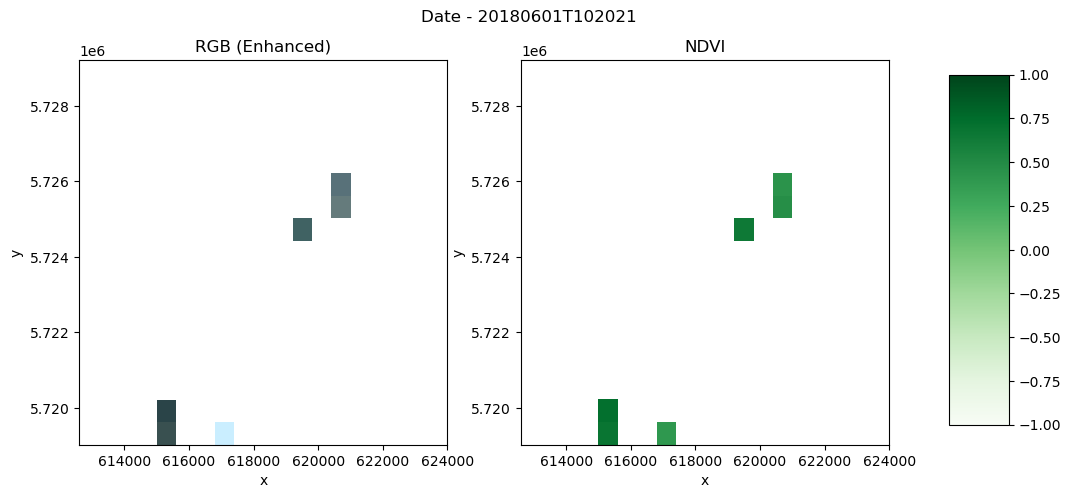

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Date - 20180601T102021\n")

# First subplot
rgb.data.plot.imshow(
    ax=ax1,
    rgb="bands",
    extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
)

ax1.set_title("RGB (Enhanced)")

# Second plot
ndvi_plot = ndvi.data.plot(ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False)
ax2.set_title("NDVI")

# Add color bar on the right
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ndvi_plot, cax=cbar_ax)

##  Yearly mean 

In [29]:
%%time
# Group by year and compute mean
# yearly_da = bbox_reproj.groupby("time.year").mean(dim="time", skipna=True)
yearly_da = (
    cloudless_ndvi.sel(x=x_slice, y=y_slice)
    .groupby("time.year")
    .mean(dim="time", skipna=True)
)
yearly_da

CPU times: user 77.2 ms, sys: 8.74 ms, total: 86 ms
Wall time: 78.8 ms


<xarray.DataArray 'data' (bands: 4, year: 6, y: 17, x: 19)> Size: 62kB
dask.array<transpose, shape=(4, 6, 17, 19), dtype=float64, chunksize=(1, 1, 13, 10), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 152B 6.129e+05 6.135e+05 ... 6.231e+05 6.237e+05
  * y        (y) float64 136B 5.729e+06 5.728e+06 ... 5.72e+06 5.719e+06
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

### Visualize NDVI for 2018

In [30]:
def plot_rgb_ndvi(dset, year, scaling, add_offset, x_slice, y_slice):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Date - " + str(year) + "\n")

    # First subplot
    rgb = dset.sel(bands=slice(band4, band2)) * scaling_factor_band4 + add_offset_band4
    rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
    rgb = rgb.clip(0, 1)  # Clip to valid range
    rgb.plot.imshow(
        ax=ax1,
        rgb="bands",
        extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
    )
    ax1.set_title("RGB (Enhanced)")

    # Second plot
    ndvi_plot = dset.sel(bands="ndvi").plot(
        ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False
    )
    ax2.set_title("NDVI")

    # Add color bar on the right
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(ndvi_plot, cax=cbar_ax)

In [31]:
%%time
year = 2018
# Select year (descending y)
year = 2018  # Adjust if more years
region = yearly_da.sel(year=year, x=x_slice, y=y_slice)

region

CPU times: user 1.13 ms, sys: 25 µs, total: 1.16 ms
Wall time: 1.11 ms


<xarray.DataArray 'data' (bands: 4, y: 17, x: 19)> Size: 10kB
dask.array<getitem, shape=(4, 17, 19), dtype=float64, chunksize=(1, 13, 10), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 152B 6.129e+05 6.135e+05 ... 6.231e+05 6.237e+05
  * y        (y) float64 136B 5.729e+06 5.728e+06 ... 5.72e+06 5.719e+06
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
    year     int64 8B 2018
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

CPU times: user 4.75 s, sys: 868 ms, total: 5.62 s
Wall time: 20.4 s


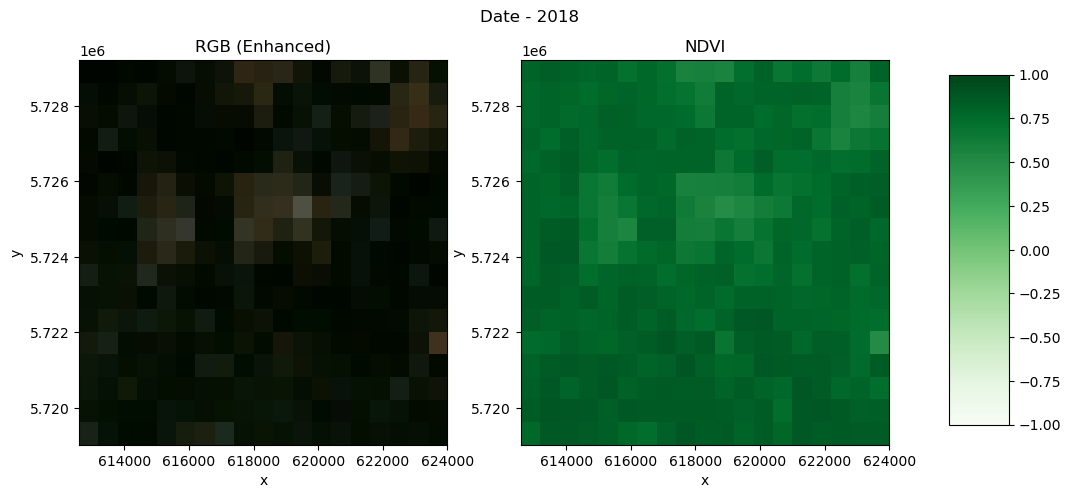

In [32]:
%%time
plot_rgb_ndvi(region, year, scaling_factor_band4, add_offset_band4, x_slice, y_slice)

## Visualise NDVI from 2018 to 2023

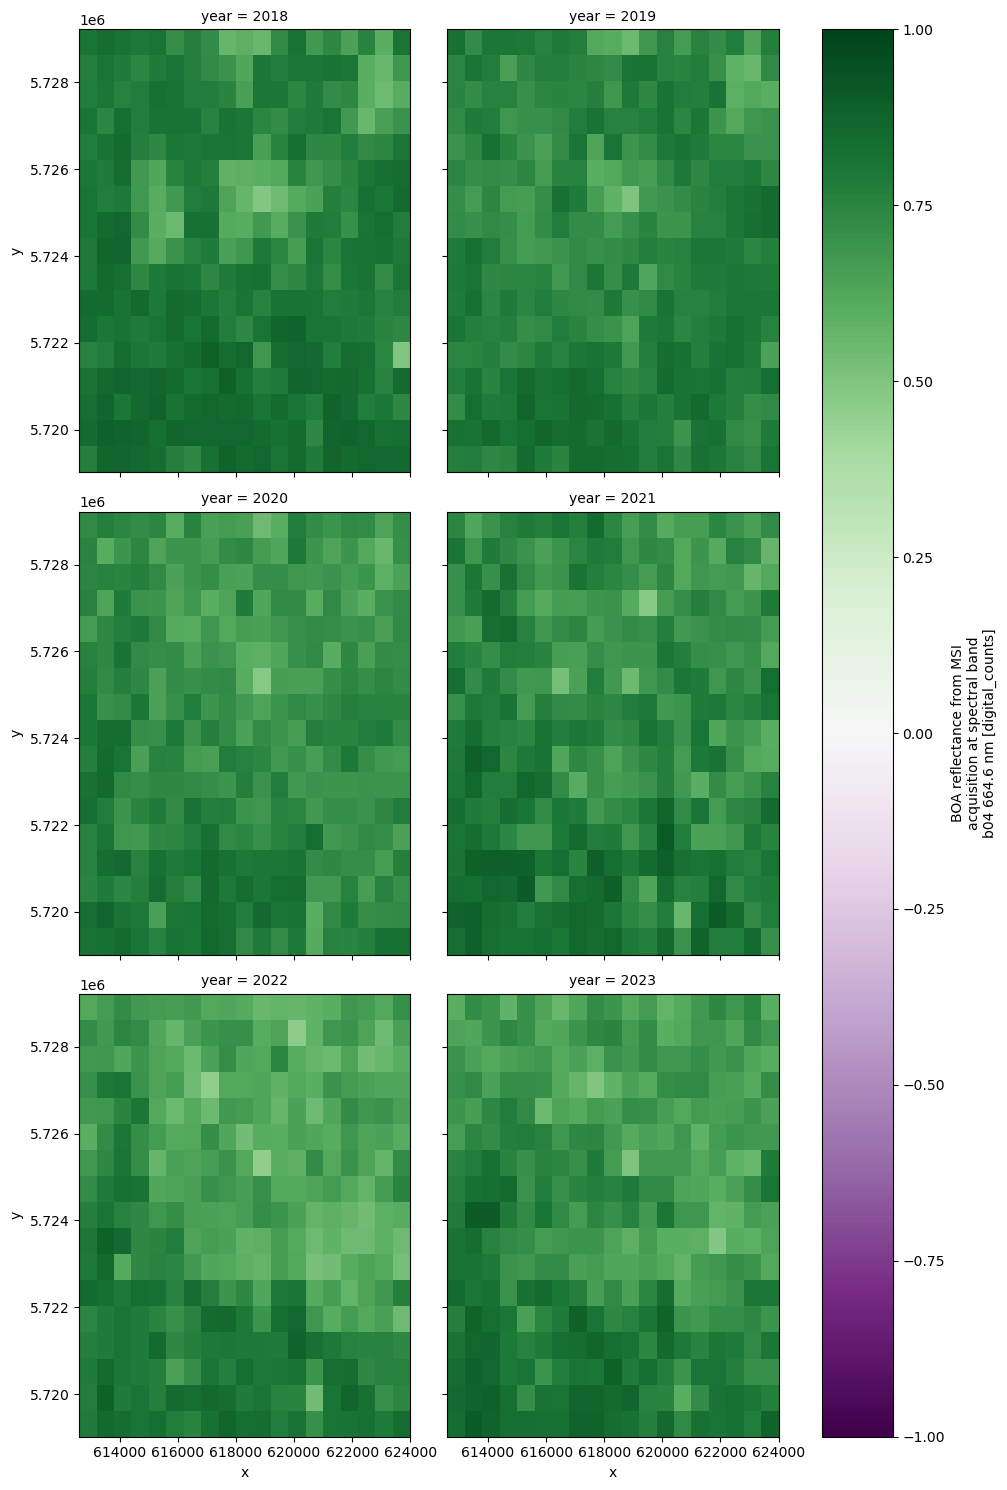

In [33]:
# Select NDVI and plot per year (smaller region for speed)
ndvi_yearly = yearly_da.sel(bands="ndvi", x=x_slice, y=y_slice).sel(
    year=slice(2018, 2023)
)

ndvi_yearly.plot(
    cmap="PRGn", x="x", y="y", col="year", col_wrap=2, vmin=-1, vmax=1, figsize=(10, 15)
)

## Create Xarray with NDVI and corresponding bands as variables

Rather than organizing the Xarray as a single DataArray with all the bands and NDVI as coordinates, we can structure it so that the coordinates represent the geographical extent of the area (x, y), and the bands become separate variables.

We create a new Xarray Dataset below with bands and NDVI as variables

In [34]:
ndvi_ds = xr.Dataset(
    {
        "NDVI": yearly_da.sel(bands="ndvi").drop_vars("bands"),
        "B04": yearly_da.sel(bands=band4).drop_vars("bands"),
        "B03": yearly_da.sel(bands=band3).drop_vars("bands"),
        "B02": yearly_da.sel(bands=band2).drop_vars("bands"),
    }
)
ndvi_ds

<xarray.Dataset> Size: 62kB
Dimensions:  (x: 19, y: 17, year: 6)
Coordinates:
  * x        (x) float64 152B 6.129e+05 6.135e+05 ... 6.231e+05 6.237e+05
  * y        (y) float64 136B 5.729e+06 5.728e+06 ... 5.72e+06 5.719e+06
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
Data variables:
    NDVI     (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>
    B04      (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>
    B03      (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>
    B02      (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>

### Saving yearly NDVI into local Zarr

- Prepare dataset to be saved with a particular attention to chunks

In [35]:
ndvi_ds

<xarray.Dataset> Size: 62kB
Dimensions:  (x: 19, y: 17, year: 6)
Coordinates:
  * x        (x) float64 152B 6.129e+05 6.135e+05 ... 6.231e+05 6.237e+05
  * y        (y) float64 136B 5.729e+06 5.728e+06 ... 5.72e+06 5.719e+06
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
Data variables:
    NDVI     (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>
    B04      (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>
    B03      (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>
    B02      (year, y, x) float64 16kB dask.array<chunksize=(1, 4, 9), meta=np.ndarray>

In [36]:
ndvi_ds.data_vars.items()

ndvi_ds = ndvi_ds.chunk({"year": 1, "y": 50, "x": 55})
print(ndvi_ds)
print(ndvi_ds.chunks)

<xarray.Dataset> Size: 62kB
Dimensions:  (x: 19, y: 17, year: 6)
Coordinates:
  * x        (x) float64 152B 6.129e+05 6.135e+05 ... 6.231e+05 6.237e+05
  * y        (y) float64 136B 5.729e+06 5.728e+06 ... 5.72e+06 5.719e+06
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
Data variables:
    NDVI     (year, y, x) float64 16kB dask.array<chunksize=(1, 17, 19), meta=np.ndarray>
    B04      (year, y, x) float64 16kB dask.array<chunksize=(1, 17, 19), meta=np.ndarray>
    B03      (year, y, x) float64 16kB dask.array<chunksize=(1, 17, 19), meta=np.ndarray>
    B02      (year, y, x) float64 16kB dask.array<chunksize=(1, 17, 19), meta=np.ndarray>
Frozen({'year': (1, 1, 1, 1, 1, 1), 'y': (17,), 'x': (19,)})


In [37]:
%%time
from zarr.codecs import BloscCodec

compressor = BloscCodec(cname="zstd", clevel=3, shuffle="bitshuffle", blocksize=0)

encoding = {}

for var in ndvi_ds.data_vars:
    encoding[var] = {"compressors": [compressor]}
for coord in ndvi_ds.coords:
    encoding[coord] = {"compressors": [compressor]}
ndvi_ds.to_zarr("ndvi_yearly.zarr", zarr_format=3, encoding=encoding, mode="w")

/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/api/asynchronous.py:205: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 13.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 16.2 s, sys: 2.25 s, total: 18.4 s
Wall time: 34.6 s


(Analysis)=
## Analysis

For analysis the first step is to classify pixels as forest. In our case we will just do a simple thresholding classification where we classify everything above a certain threshold as forest. This isn't the best approach for classifying forest, since agricultural areas can also easily reach very high NDVI values. A better approach would be to classify based on the temporal signature of the pixel. 

However, for this basic analysis, we stick to the simple thresholding approach.

In this case we classify everything above an NDVI of 0.7 as forest. This calculated forest mask is then saved to a new Data Variable in the xarray dataset: 

In [38]:
ndvi_ds["FOREST"] = ndvi_ds.NDVI > 0.7

With this forest mask we can already do a quick preliminary analysis to plot the total forest area over the years.

To do this we sum up the pixels along the x and y coordinate but not along the time coordinate. This will leave us with one value per year representing the number of pixels classified as forest. We can then calculate the forest area by multiplying the number of forest pixels by the resolution.

In [39]:
def to_km2(dataarray, resolution):
    # Calculate forest area
    return dataarray * np.prod(list(resolution)) / 1e6

In [40]:
resolution = (10 * factor, 10 * factor)
print("factor = ", factor, "resolution = ", resolution)
forest_pixels = ndvi_ds.sel(x=x_slice, y=y_slice).FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2

factor =  10 resolution =  (100, 100)


<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
dask.array<truediv, shape=(6,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

In [41]:
forest_area_km2.load()

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
array([2.74, 2.73, 2.17, 2.31, 1.48, 1.84])
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

In [42]:
forest_area_km2

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
array([2.74, 2.73, 2.17, 2.31, 1.48, 1.84])
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

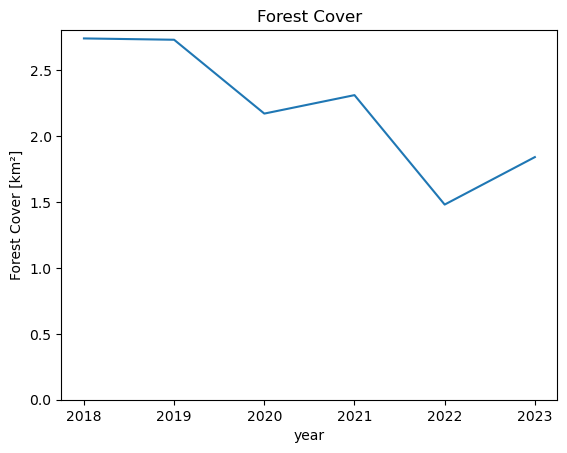

In [43]:
# forest_area_km2.sel(year=slice(2018, 2023)).plot()
forest_area_km2.plot()

plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0);

We can see that the total forest area in this AOI decreased from 2018 to 2023.

(Summary)=
## Summary

This notebook showed how to access Zarr data from the EOPF Sample Service. This includes generating cloud-free mosaics and calculating spectral indices from data stored in cloud storage. 

It also showed how to import this data using xarray and carry out simple computation uch as computing NDVI.

In [49]:
client.close()

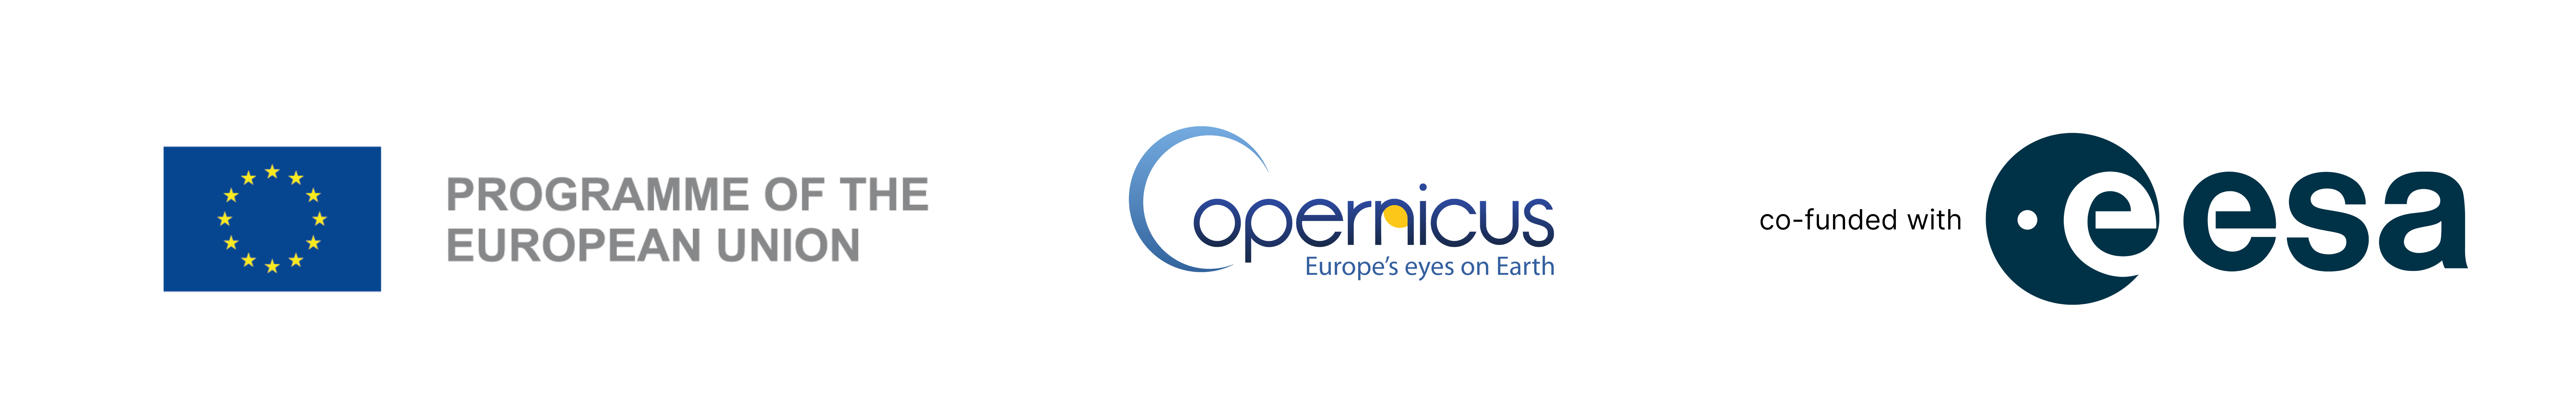